<font size = "6"> Fordham Sports Analytics Society Big Data Bowl 2023 - Exploratory Analysis </font>

<font size = "4"> Run through ideas for eventual model, create new model features, and understand provided materials. </font>

- Authors:  Peter Majors, Chris Orlando, and Jack Townsend
- Kaggle:  https://www.kaggle.com/competitions/nfl-big-data-bowl-2023/overview (Resources)
- Our Github:  https://github.com/peterlmajors/FSAS_BigDataBowl_2023 (Up-To-Date Code)

In [96]:
#Import Required Packages

#Data Manipulation
import pandas as pd
import numpy as np
import math

#Data Vizualization
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go

#Notebook Settings
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [111]:
#Importing Kaggle Data (Needed For Animated Plays Function (Takes Original Data))

# #Games - Basic Information On All Games
games = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/games.csv")

# #pffScout - PFF Judgements For Each Player On Each Play
pffScout = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/pffScoutingData.csv")

# #Players - Basics On Players
players = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/players.csv")

# #Plays - Everthing About Specific Plays
plays = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/plays.csv")

# #Week - Frame-By-Frame Player Tracking
week1 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week1.csv")
week2 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week2.csv")
week3 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week3.csv")
week4 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week4.csv")
week5 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week5.csv")
week6 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week6.csv")
week7 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week7.csv")
week8 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week8.csv")

In [107]:
#Define Function To Animate Plays (Needed)
colors = {'ARI':"#97233F", 'ATL':"#A71930", 'BAL':'#241773', 'BUF':"#00338D", 'CAR':"#0085CA", 'CHI':"#C83803", 'CIN':"#FB4F14", 'CLE':"#311D00", 
          'DAL':'#003594', 'DEN':"#FB4F14", 'DET':"#0076B6", 'GB':"#203731", 'HOU':"#03202F", 'IND':"#002C5F", 'JAX':"#9F792C", 'KC':"#E31837", 
          'LA':"#003594", 'LAC':"#0080C6", 'LV':"#000000", 'MIA':"#008E97", 'MIN':"#4F2683", 'NE':"#002244", 'NO':"#D3BC8D", 'NYG':"#0B2265", 
          'NYJ':"#125740", 'PHI':"#004C54", 'PIT':"#FFB612", 'SEA':"#69BE28", 'SF':"#AA0000", 'TB':'#D50A0A', 'TEN':"#4B92DB", 'WAS':"#5A1414", 
          'football':'#CBB67C'}

def animate_play(tracking_df, play_df,players,pffScoutingData, gameId,playId):
    selected_play_df = play_df[(play_df.playId==playId)&(play_df.gameId==gameId)].copy()
    
    tracking_players_df = pd.merge(tracking_df,players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()

    # get play General information 
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    first_down_marker = line_of_scrimmage + selected_play_df.yardsToGo.values[0]
    down = selected_play_df.down.values[0]
    quarter = selected_play_df.quarter.values[0]
    gameClock = selected_play_df.gameClock.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
        {
             "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field 
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[53.5-5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add line of scrimage 
        data.append(
            go.Scatter(
                x=[line_of_scrimmage,line_of_scrimmage], 
                y=[0,53.5],
                line_dash='dash',
                line_color='blue',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add First down line 
        data.append(
            go.Scatter(
                x=[first_down_marker,first_down_marker], 
                y=[0,53.5],
                line_dash='dash',
                line_color='yellow',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Plot Players
        for team in selected_tracking_df.team.unique():
            plot_df = selected_tracking_df[(selected_tracking_df.team==team)&(selected_tracking_df.frameId==frameId)].copy()
            if team != "football":
                hover_text_array=[]
                for nflId in plot_df.nflId:
                    selected_player_df = plot_df[plot_df.nflId==nflId]
                    hover_text_array.append("nflId:{}<br>displayName:{}<br>Position:{}<br>Role:{}".format(selected_player_df["nflId"].values[0],
                                                                                      selected_player_df["displayName"].values[0],
                                                                                      selected_player_df["pff_positionLinedUp"].values[0],
                                                                                      selected_player_df["pff_role"].values[0]))
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hovertext=hover_text_array,hoverinfo="text"))
            else:
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hoverinfo='none'))
        # add frame to slider
        slider_step = {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"}
        sliders_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=10
    layout = go.Layout(
        autosize=False,
        width=120*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{playDescription}",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]["data"],
        layout= layout,
        frames=frames[1:]
    )
    # Create First Down Markers 
    for y_val in [0,53]:
        fig.add_annotation(
                x=first_down_marker,
                y=y_val,
                text=str(down),
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="black"
                    ),
                align="center",
                bordercolor="black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=1
                )

    return fig

In [143]:
#Import Our Merged DataFrames (Needed)
ptrack = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/merged_data/ptrack.csv")
pbp = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/merged_data/pbp.csv")

<font size="5">Check Out Individual Plays</font>

Specific Play From This Game
- Video = https://nfl-video.com/archive/nfl_replay/nfl_2021_22/dallas_cowboys_vs_tampa_bay_buccaneers_full_game_replay_2021_nfl_week_1/47-1-0-539

- gameId = 2021090900

- playId = 97

In [150]:
#Run Animate Plays Function

#Choose A Game and Play
gameId = 2021091300
playId = 2655

#Print The Play!
animate_play(week1, plays, players, pffScout, gameId, playId)

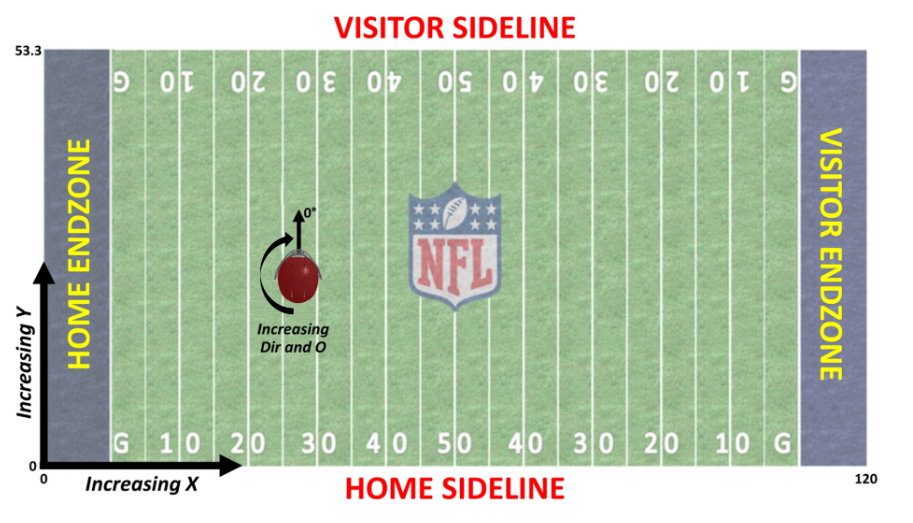

In [133]:
#Print Out All Frames From Selected Play
#ptrack.loc[(ptrack['gameId'] == gameId)].sort_values(by = 'angle_to_qb', ascending = False).head(100)

#Print Out Single Frame From Selected Play
#ptrack.loc[(ptrack['gameId'] == gameId) & (ptrack['playId'] == playId) & (ptrack['frameId'] == 1)]

#Print Out All Plays From Selected Game
#ptrack[(ptrack.gameId == gameId) & (ptrack.playDirection == 'right')]['playId'].sort_values().unique()

#Print Out All pbp Data From Selected Play
#pbp[(pbp['gameId'] == gameId) & (pbp['playId'] == playId)]

#Print Out All pffScout Data From Selected Play
#pffScout.loc[(pffScout['gameId'] == gameId) & (pffScout['playId'] == playId)]

array([  97,  410,  434,  456,  480,  509,  559,  583,  869,  925,  947,
       1078, 1368, 1392, 1425, 1506, 1563, 1587, 1687, 1726, 1776, 1918,
       1940, 2088, 2129, 2169, 2211, 2233, 2257, 2279, 2298, 2330, 2530,
       2554, 2632, 2656, 2678, 2735, 2780, 3014, 3216, 3261, 3306, 3330,
       3364, 3406, 3588, 3633, 3655, 3793, 3862, 3909, 3933, 3962, 4538,
       4560, 4624, 4653, 4677, 4699, 4728, 4750, 4772], dtype=int64)

<font size="5">Explore Relevant Time Frames For QB With Football</font>

In [ ]:
#Find All DRTs In The Game (And Number of Frames In Game)
ptrack[(ptrack.pff_positionLinedUp == 'DRT') & (ptrack.gameId == gameId)][['team', 'displayName']].value_counts()

team  displayName        
DAL   Quinton Bohanna        437
TB    Vita Vea               435
DAL   Brent Urban            331
TB    Ndamukong Suh          260
      William Gholston       227
      Steve McLendon         198
DAL   Osa Odighizuwa         163
TB    Rakeem Nunez-Roches    136
DAL   Carlos Watkins         117
      Dorance Armstrong       36
TB    Jason Pierre-Paul       32
dtype: int64

In [ ]:
# #Frequency of Certain Plays
# ptrack_filtered = np.where(ptrack.pff_positionLinedUp == "QB")
# display(ptrack.loc[ptrack_filtered]['event'].value_counts())

# #Chris To Identify These Events As Plays Where We Want To Start And End D-Line Interest w/ QB
# Define The Time Duration of Interest

<font size="5">Explore Effect Of Block Types On Hurry Rate</font>

In [ ]:
#For Each Block Type, Find The Success Rate of A Defesnvie Player Creating A Pressure

# #How We Found Positions
# #pffScout.pff_positionLinedUp.sort_values().unique()

# #Create A New Data Frame Only With 9 D-Linemen Positons
# ptrackl = ptrack.loc[(ptrack['pff_positionLinedUp'] == "LOLB") | (ptrack['pff_positionLinedUp'] == "ROLB") | (ptrack['pff_positionLinedUp'] == "LEO") |
#     (ptrack['pff_positionLinedUp'] == "REO") | (ptrack['pff_positionLinedUp'] == "DLT") | (ptrack['pff_positionLinedUp'] == "DRT") |
#     (ptrack['pff_positionLinedUp'] == "NLT") | (ptrack['pff_positionLinedUp'] == "NRT") | (ptrack['pff_positionLinedUp'] == "NT")]

# #Must First Change The pff_blockType in ptrack To A String (Data Did Not Group By Properly When An Int)
# ptrackl.pff_blockType = ptrack.pff_blockType.astype("str")

# #For Each Block Type, Find The Percentage of Time A Hury Occurs
# ptrackl.groupby('pff_blockType')['pff_hurry'].count() #Ideally Would Be .average() Instead

# #Frequency of Different Type of Blocks Performed (EDA)
# #ptrack.pff_blockType.value_counts()

# #Issue Is Only The Players Issuing The Block (Offensive Players) Are Assigned A Block Type
# #However, The Defensive Players They Blocked Are Noted In The pff_nflIdBlockedPlayer Column In ptrack

C:\Users\Peter\AppData\Local\Temp\ipykernel_9868\3845793339.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptrackl.pff_blockType = ptrack.pff_blockType.astype("str")


pff_blockType
0    1315558
Name: pff_hurry, dtype: int64

In [ ]:
# #Create A Data Frame Containing Only Plays Where A Pass Block Occured (One Row Per Block)
# ptrack_blocks = ptrack.loc[ptrack['pff_blockType'] != '0'][['gameId', 'playId', 'nflId', 'pff_nflIdBlockedPlayer', 'pff_blockType', 'pff_hurryAllowed']]

# #Reduce To Each Play (One Row Per Interaction Between Blocked Player And Blocker) (First Interation of A Defensive Player Being Blocked In Play)
# ptrack_blocks = ptrack_blocks.drop_duplicates() 

# #Sampler of The ptrack_blocks Data Frame
# ptrack_blocks.sort_values('gameId', ascending = False).head(5)

# #Show How Often Each Block Type Resulted In A Hurry
# ptrack_block_hurry = pd.DataFrame(ptrack_blocks.groupby('pff_blockType')['pff_hurryAllowed'].mean().round(4).sort_values(ascending = False))
# ptrack_block_hurry

,pff_hurryAllowed
pff_blockType,
PU,0.1061
SW,0.0658
UP,0.0584
PP,0.0574
PA,0.0306
BH,0.0248
PT,0.0176
PR,0.0136
SR,0.0100


In [ ]:
# #Can Each Offensive Player Only Get One Block Per Play (I'd Assume Not, But Lets Check) (Yes They Do!)
# ptrack_blocks_per_play = pd.DataFrame(ptrack_blocks.groupby(['gameId', 'playId', 'nflId'])['pff_blockType'].count())
# ptrack_blocks_per_play = ptrack_blocks_per_play.reset_index()

# ptrack_blocks_per_play[ptrack_blocks_per_play['pff_blockType'] != 1].head() #No Rows Appear
# #Yes! Each Offensive Player Only Gets One Block Per Play!

,gameId,playId,nflId,pff_blockType


<font size="5"> Explore  Distance From Quarterback At Each Second </font>

Each D-Line Position and Each Second Post Snap

In [ ]:
#Create Role-Specific Data Frames
ptrack_prush = ptrack[ptrack.pff_role == "Pass Rush"]
ptrack_pblock = ptrack[ptrack.pff_role == "Pass Block"]

#Descriptive Stats On Frames In Plays
pd.DataFrame(ptrack.groupby(['gameId', 'playId'])['frameId'].max()).mean()

#Available Roles On The Field
ptrack.pff_role.value_counts()

#Top 8 Most Popular Pass Rush Positions
ptrack_prush.pff_positionLinedUp.value_counts().reset_index().head(8)

,index,pff_positionLinedUp
0,DRT,200010
1,LEO,194144
2,DLT,182813
3,REO,178836
4,ROLB,169348
5,LOLB,161725
6,LE,132991
7,RE,99250


Text(0, 0.5, 'Euclidead Distance From Quarterback')

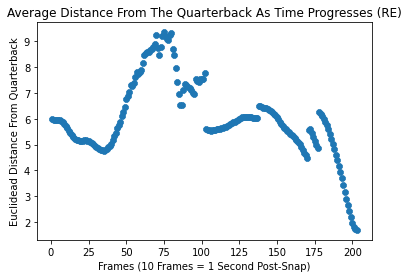

In [ ]:
#Display Scatter Plot
ptrack_prush_drt_dist_from_qb = ptrack_prush[ptrack_prush['pff_positionLinedUp'] == 'RE'].groupby('frameId')['dist_from_qb'].mean().reset_index()
plt.scatter(x = ptrack_prush_drt_dist_from_qb.frameId, y = ptrack_prush_drt_dist_from_qb.dist_from_qb, marker = "8")
plt.title("Average Distance From The Quarterback As Time Progresses (RE)")
plt.xlabel("Frames (10 Frames = 1 Second Post-Snap)")
plt.ylabel("Euclidead Distance From Quarterback")

<font size="5"> Explore Angle of Offensive Linemen Relative To Direction of Pass Rusher During and After Contact </font>

In [151]:
#Look At Specific Frame
ptrack[(ptrack.gameId == gameId) & (ptrack.playId == playId) & (ptrack.frameId == 51)][['gameId', 'playId', 'nflId', 'frameId','displayName', 'dir', 'o', 'angle_to_qb']]

,gameId,playId,nflId,frameId,displayName,dir,o,angle_to_qb
7913004,2021091300,2655,40042,51,Brandon Williams,208.68,201.14,359.877554
7913005,2021091300,2655,41265,51,Derek Carr,204.39,206.83,0.000000
7913006,2021091300,2655,42547,51,Darren Waller,202.47,233.83,270.496642
7913007,2021091300,2655,44828,51,Marlon Humphrey,174.47,161.10,276.361829
7913008,2021091300,2655,44859,51,Tyus Bowser,189.01,198.12,1.239298
7913009,2021091300,2655,44999,51,Chuck Clark,206.71,200.34,336.647981
7913010,2021091300,2655,46084,51,Kolton Miller,181.91,179.49,352.914395
7913011,2021091300,2655,46187,51,Anthony Averett,165.90,125.16,269.599169
7913012,2021091300,2655,46259,51,DeShon Elliott,200.95,87.18,270.600249
7913013,2021091300,2655,48233,51,Alec Ingold,251.86,246.47,358.904331


<font size="5"> Explore Events Classifications (Understand Beginning and End Of QB Possession) </font>

Starting at: ball_snap

Ending At: qb_sack, pass_forward, run, 

Bookmarked: first_contact, 

In [ ]:
#Determine Which Events Are The End Of QB Possession
ptrack.event.value_counts()

None                         7339728
ball_snap                     187704
pass_forward                  166056
autoevent_ballsnap             82874
autoevent_passforward          82148
play_action                    43494
run                            10428
qb_sack                         9922
pass_arrived                    8074
autoevent_passinterrupted       4422
man_in_motion                   3894
line_set                        3080
shift                           2926
pass_tipped                     2442
first_contact                   1760
qb_strip_sack                   1276
pass_outcome_incomplete          880
pass_outcome_caught              506
fumble                           374
fumble_offense_recovered         242
handoff                          220
tackle                            66
huddle_break_offense              66
penalty_flag                      44
out_of_bounds                     22
dropped_pass                      22
lateral                           22
N

In [ ]:
#Use Event Classification To Find Play Information In pbp Data
ptrack_fc = ptrack[ptrack.event == 'first_contact']
pbp_fc = pbp.merge(ptrack_fc, how = 'inner', on = ['gameId', 'playId'])
pbp_fc.drop_duplicates(['gameId', 'playId'])

#Additional Searches
# ptrack.loc[(ptrack.gameId == 2021091204) & (ptrack.playId == 1979) & (ptrack.pff_positionLinedUp == 'QB')] 

,Unnamed: 0_x,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,Unnamed: 0_y,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,height,weight,birthDate,collegeName,officialPosition,displayName,x_qb,y_qb,s_qb,a_qb,dis_qb,o_qb,dir_qb,dist_from_qb,angle_to_qb
0,431,2021091204,2021,1,09/12/2021,13:00:00,DET,SF,1979,(:28) (Shotgun) J.Garoppolo scrambles up the m...,2,1,10,SF,DET,DET,25,00:28,10,28,R,NaN,3,3,NaN,NaN,NaN,NaN,NaN,NaN,35.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"3 DL, 2 LB, 6 DB",SCRAMBLE,0,Cover-3,Zone,4315168,34472,Pass Block,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42444.0,CL,0.0,31,2021-09-12T18:28:45.500,50.0,SF,left,39.51,23.75,2.47,0.61,0.25,175.05,139.63,first_contact,6-4,311,1985-11-19,California,C,Alex Mack,42.99,24.06,0.99,2.35,0.09,305.97,284.89,3.49,0.45
22,568,2021091206,2021,1,09/12/2021,13:00:00,IND,SEA,98,(14:20) (Shotgun) C.Wentz sacked at IND 19 for...,1,3,9,IND,SEA,IND,26,14:20,0,0,S,5.0,-7,5,Defensive Offside,44818.0,NaN,NaN,NaN,NaN,84.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 4 LB, 5 DB",NaN,0,Cover-1,Man,5200558,35493,Coverage,LEO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,34,2021-09-12T17:08:29.600,8.0,SEA,left,79.87,27.45,2.23,3.95,0.22,84.54,316.20,first_contact,6-6,285,1989-02-28,Florida,OLB,Carlos Dunlap,92.50,26.47,3.88,3.12,0.38,317.52,317.01,12.67,0.34
44,577,2021091206,2021,1,09/12/2021,13:00:00,IND,SEA,742,(:01) (Shotgun) C.Wentz sacked at IND 21 for -...,1,3,5,IND,SEA,IND,30,00:01,3,7,S,NaN,-9,-9,NaN,NaN,NaN,NaN,NaN,NaN,80.0,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-6,Zone,5203572,35493,Pass Rush,LEO,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,35,2021-09-12T17:36:15.300,8.0,SEA,left,89.43,23.86,5.15,2.97,0.52,183.71,157.66,first_contact,6-6,285,1989-02-28,Florida,OLB,Carlos Dunlap,88.66,22.26,3.34,4.10,0.32,175.36,134.40,1.78,76.96
66,592,2021091206,2021,1,09/12/2021,13:00:00,IND,SEA,1668,(1:23) (Shotgun) R.Wilson sacked at SEA 31 for...,2,1,15,SEA,IND,SEA,36,01:23,10,14,S,NaN,-5,-5,NaN,NaN,NaN,NaN,NaN,NaN,74.0,EMPTY,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-2,Zone,5526466,33107,Pass Block,LT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53450.0,PP,0.0,32,2021-09-12T18:19:07.000,76.0,SEA,left,82.36,24.50,3.00,2.59,0.31,227.67,39.60,first_contact,6-4,315,1985-08-30,Virginia Tech,T,Duane Brown,81.37,27.51,2.50,0.78,0.25,278.31,328.48,3.17,83.83
88,601,2021091206,2021,1,09/12/2021,13:00:00,IND,SEA,2111,(11:26) (Shotgun) C.Wentz pass incomplete shor...,3,3,3,IND,SEA,IND,19,11:26,10,21,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,29.0,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-6,Zone,5211030,35493,Pass Rush,LEO,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,58,2021-09-12T18:50:19.300,8.0,SEA,right,18.60,20.77,4.20,4.58,0.45,296.20,210.82,first_contact,6-6,285,1989-02-28,Florida,OLB,Carlos Dunlap,17.63,21.61,1.59,7.30,0.19,92.82,168.83,1.28,36.87
110,616,2021091206,2021,1,09/12/2021,13:00:00,IND,SEA,3060,(10:00) (Shotgun) C.Wentz sacked at SEA 27 for...,4,4,2,IND,SEA,SEA,18,10:00,10,21,S,NaN,-9,-9,NaN,NaN,NaN,NaN,NaN,NaN,28.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-6,Zone,5321998,38577,Coverage,MLB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,35,2021-09-12T19:30:12.000,54.0,SEA,left,21.98,21.63,4.21,4.04,0.43,104.50,198.52,first_contact,6-0,242,1990-06-27,Utah State,MLB,Bobby Wagner,36.24,28.57,2.06,3.27,0.19,351.73,179.78,15.86,13.33
1

<font size="5"> Explore Drop Back Types </font>

In [136]:
#Frequency of Drop Backs Types
pbp.dropBackType.value_counts()

TRADITIONAL               6542
SCRAMBLE                   899
DESIGNED_ROLLOUT_RIGHT     285
DESIGNED_ROLLOUT_LEFT      149
SCRAMBLE_ROLLOUT_RIGHT     125
SCRAMBLE_ROLLOUT_LEFT       23
DESIGNED_RUN                 5
UNKNOWN                      1
Name: dropBackType, dtype: int64

In [140]:
pbp.groupby('dropBackType')['defendersInBox'].mean().sort_values()

dropBackType
UNKNOWN                   5.000000
SCRAMBLE                  5.797553
TRADITIONAL               5.970957
DESIGNED_RUN              6.600000
SCRAMBLE_ROLLOUT_RIGHT    6.856000
DESIGNED_ROLLOUT_RIGHT    6.894737
DESIGNED_ROLLOUT_LEFT     6.912752
SCRAMBLE_ROLLOUT_LEFT     6.913043
Name: defendersInBox, dtype: float64